In [1]:
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import io
import string
import tqdm

In [2]:
# User define variable and Setup
import warnings
warnings.filterwarnings("ignore")

# Set max column display is 100 row
pd.set_option('display.max_columns', 100)

In [3]:
import os
os.chdir('/content/drive/MyDrive/Project_03')
os.listdir()

['CBD_Project03_AuthorClassification.ipynb',
 'gutenberg_data.csv',
 'my_data.csv',
 'data_top_ten.csv',
 'logs',
 'w2vmodel',
 'vectors.tsv',
 'metadata.tsv',
 'data_train.csv',
 'data_test.csv',
 'saved_weights.pt']

In [4]:
org_data = pd.read_csv("gutenberg_data.csv")
display(org_data.head())
print(org_data.shape) 

,Title,Author,Link,ID,Bookshelf,Text
0,The Extermination of the American Bison,William T. Hornaday,http://www.gutenberg.org/ebooks/17748,17748,Animal,[Illustration: (Inscription) Mr. Theodore Roos...
1,Deadfalls and Snares,A. R. Harding,http://www.gutenberg.org/ebooks/34110,34110,Animal,DEADFALLS AND SNARES [Frontispiece: A GOOD DEA...
2,Artistic Anatomy of Animals,Édouard Cuyer,http://www.gutenberg.org/ebooks/38315,38315,Animal,+---------------------------------------------...
3,"Birds, Illustrated","Color Photography, Vol. 1, No. 1 Various",http://www.gutenberg.org/ebooks/30221,30221,Animal,FROM: THE PRESIDENT OF THE NATIONAL TEACHERS' ...
4,On Snake-Poison: Its Action and Its Antidote,A. Mueller,http://www.gutenberg.org/ebooks/32947,32947,Animal,[Illustration] ON SNAKE-POISON. ITS ACTION AND...


(15331, 6)


In [5]:
author_name = org_data.Author.value_counts()[:10].index
author_name

Index(['Various', 'G. A. Henty', 'Anonymous', 'R. M. Ballantyne',
       'Georg Ebers', 'L. Frank Baum', 'Laura Lee Hope', 'Walter Scott',
       'Baron Edward Bulwer Lytton Lytton', 'Thornton W. Burgess'],
      dtype='object')

In [6]:
data = pd.DataFrame()
data_train = pd.DataFrame()
data_test = pd.DataFrame()
for author in author_name:
  author = org_data[org_data.Author == author]
  data = data.append(author[:10])
  data_train = data_train.append(author[:7])
  data_test = data_test.append(author[7:10])
display(data_train.head())
print(data_train.shape)
display(data_test.head())
print(data_test.shape)

,Title,Author,Link,ID,Bookshelf,Text
392,Poems Teachers Ask For,Various,http://www.gutenberg.org/ebooks/18909,18909,Children's,POEMS TEACHERS ASK FOR Selected by READERS OF ...
395,First Italian Readings,Various,http://www.gutenberg.org/ebooks/24072,24072,Children's,Transcriber's note: Text enclosed by equal sig...
582,The Night Before Christmas and Other Popular S...,Various,http://www.gutenberg.org/ebooks/13213,13213,Christmas,and The Internet Archive Children's Library [T...
593,A Christmas Hamper: A Volume of Pictures and S...,Various,http://www.gutenberg.org/ebooks/53299,53299,Christmas,images of public domain material from the Goog...
776,Le Tour du Monde; Athos,Various,http://www.gutenberg.org/ebooks/24515,24515,Greece,Online Distributed Proofreading Team at http:/...


(70, 6)


,Title,Author,Link,ID,Bookshelf,Text
1350,The Brochure Series of Architectural Illustrat...,Various,http://www.gutenberg.org/ebooks/25735,25735,The,THE BROCHURE SERIES OF ARCHITECTURAL ILLUSTRAT...
1412,"Encyclopaedia Britannica, 11th Edition, ""Andro...",Various,http://www.gutenberg.org/ebooks/13600,13600,Reference,THE ENCYCLOPÆDIA BRITANNICA - ELEVENTH EDITION...
1429,"Encyclopaedia Britannica, 11th Edition, ""Bulga...",Various,http://www.gutenberg.org/ebooks/19846,19846,Reference,Transcriber's note: A few typographical errors...
2722,The Young Colonists: A Story of the Zulu and B...,G. A. Henty,http://www.gutenberg.org/ebooks/32934,32934,Boer,The Young Colonists A Story of the Zulu and Bo...
2887,With Wolfe in Canada: The Winning of a Continent,G. A. Henty,http://www.gutenberg.org/ebooks/17766,17766,NaN,WITH WOLFE IN CANADA Or The Winning of a Conti...


(30, 6)


In [7]:
data_train = data_train.drop(columns="Link", axis = 1)
data_train = data_train.drop(columns="Bookshelf", axis = 1)
data_test = data_test.drop(columns="Link", axis = 1)
data_test = data_test.drop(columns="Bookshelf", axis = 1)
display(data_train.head())
display(data_test.head())

,Title,Author,ID,Text
392,Poems Teachers Ask For,Various,18909,POEMS TEACHERS ASK FOR Selected by READERS OF ...
395,First Italian Readings,Various,24072,Transcriber's note: Text enclosed by equal sig...
582,The Night Before Christmas and Other Popular S...,Various,13213,and The Internet Archive Children's Library [T...
593,A Christmas Hamper: A Volume of Pictures and S...,Various,53299,images of public domain material from the Goog...
776,Le Tour du Monde; Athos,Various,24515,Online Distributed Proofreading Team at http:/...


,Title,Author,ID,Text
1350,The Brochure Series of Architectural Illustrat...,Various,25735,THE BROCHURE SERIES OF ARCHITECTURAL ILLUSTRAT...
1412,"Encyclopaedia Britannica, 11th Edition, ""Andro...",Various,13600,THE ENCYCLOPÆDIA BRITANNICA - ELEVENTH EDITION...
1429,"Encyclopaedia Britannica, 11th Edition, ""Bulga...",Various,19846,Transcriber's note: A few typographical errors...
2722,The Young Colonists: A Story of the Zulu and B...,G. A. Henty,32934,The Young Colonists A Story of the Zulu and Bo...
2887,With Wolfe in Canada: The Winning of a Continent,G. A. Henty,17766,WITH WOLFE IN CANADA Or The Winning of a Conti...


In [8]:
data_train.isnull().sum()

Title     0
Author    0
ID        0
Text      0
dtype: int64

In [9]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70 entries, 392 to 321
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   70 non-null     object
 1   Author  70 non-null     object
 2   ID      70 non-null     int64 
 3   Text    70 non-null     object
dtypes: int64(1), object(3)
memory usage: 2.7+ KB


1. Data preprocessing

In [10]:
import nltk
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> stopwords
      Unzipping corpora/stopwords.zip.

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [11]:
from nltk.corpus import stopwords
print(stopwords.words("english"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [12]:
!python -m spacy download en_core_web_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.0 MB 495 kB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [13]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [14]:
data_train_size = data_train["Text"].size
data_test_size = data_test["Text"].size

In [15]:
# preprocess text data
def clean_text_data(data_point, data_size):
    review_soup = BeautifulSoup(data_point)
    review_text = review_soup.get_text()
    review_letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    review_lower_case = review_letters_only.lower()  
    review_words = review_lower_case.split()
    meaningful_words = [x for x in review_words if x not in stopwords.words("english")]
        
    return( " ".join( meaningful_words)) 

In [16]:
for i in range(data_train_size):
    data_train["Text"].iloc[i] = clean_text_data(data_train["Text"].iloc[i], data_train_size)
print("Cleanning training completed!")

Cleanning training completed!


In [17]:
for i in range(data_test_size):
    data_test["Text"].iloc[i] = clean_text_data(data_test["Text"].iloc[i], data_test_size)
print("Cleanning testing completed!")

Cleanning testing completed!


In [ ]:
# data_train.to_csv("data_train.csv", index = False)
# data_test.to_csv("data_test.csv", index = False)

In [39]:
data_train = pd.read_csv("data_train.csv")
data_test = pd.read_csv("data_test.csv")

2. Data exploration

In [18]:
df_grouped=data_train[['Author','Text']].groupby(by='Author').agg(lambda x:' '.join(x))
df_grouped.head()

,Text
Author,
Anonymous,proofreaders team https www pgdp net special t...
Baron Edward Bulwer Lytton Lytton,coming race edward bulwer lord lytton chapter ...
G. A. Henty,freedom cause g henty contents glen cairn ii l...
Georg Ebers,romance ancient egypt historical romances geor...
L. Frank Baum,made available hathitrust digital library tran...


In [20]:
# Creating Document Term Matrix
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(analyzer='word')
data=cv.fit_transform(df_grouped['Text'])
df_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
df_dtm.index=df_grouped.index
df_dtm.head(3)

,aahmes,aalu,aaron,ab,aback,abacus,abaissement,abana,abandon,abandoned,abandoning,abandonment,abandonn,abandons,abare,abart,abase,abased,abasement,abash,abashed,abasing,abate,abated,abatement,abates,abating,abattis,abb,abbachie,abbacy,abbaiare,abbair,abbandon,abbandonando,abbandonare,abbandoner,abbarach,abbas,abbassare,abbassate,abbassava,abbasso,abbastanza,abbattimento,abbe,abbelliranno,abbellire,abbelliscono,abberbredok,...,zillah,zinder,zinnias,zio,zion,zione,zip,ziri,zita,zitella,zitellona,ziz,zoan,zoar,zodiac,zodiack,zodiaques,zogirma,zographos,zone,zoned,zones,zoo,zookers,zoological,zoologist,zooloo,zoomed,zooming,zoophytes,zopyras,zopyrus,zoroaster,zotica,zouche,zounds,zoungom,zu,zubby,zucchero,zulus,zum,zummer,zurita,zurline,zutze,zuyder,zuz,zuzulia,zy
Author,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Anonymous,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
Baron Edward Bulwer Lytton Lytton,0,0,0,0,0,2,0,0,14,32,0,2,0,2,0,0,2,6,8,6,11,2,14,4,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,188,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0,3,0,0,1,0,0,0,0,0,0,2,0,0,6,0,1,0,0,0,0,3,0,0,1,2,0,1,0
G. A. Henty,0,0,1,0,0,0,0,0,18,38,7,2,0,0,0,0,0,0,0,0,4,0,4,17,1,1,2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,1,...,1,0,0,0,6,0,0,0,6,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0


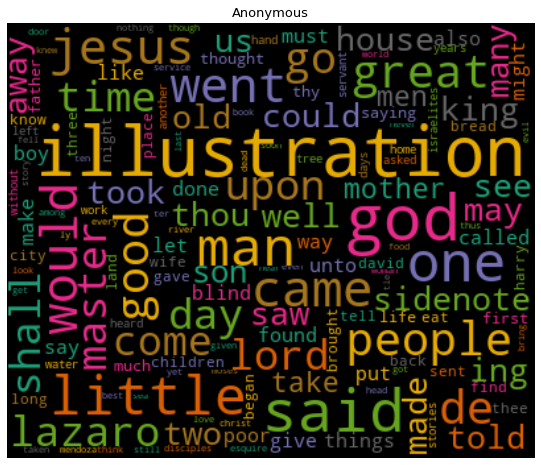

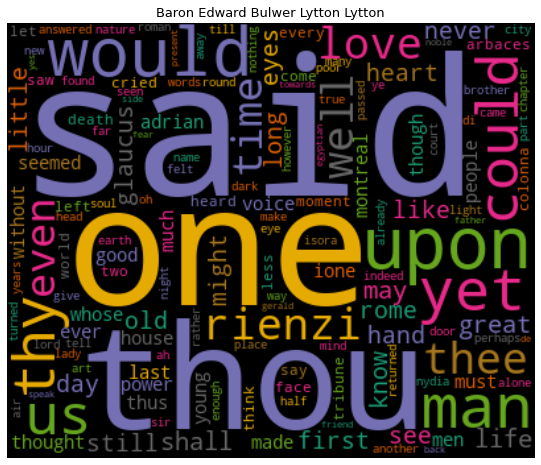

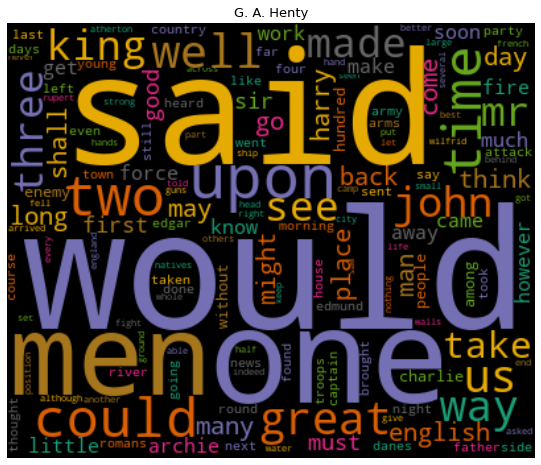

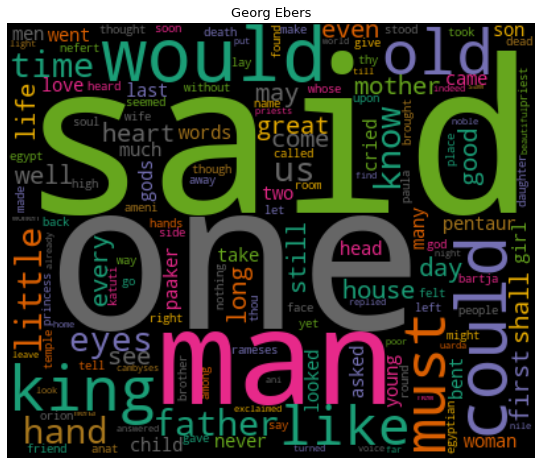

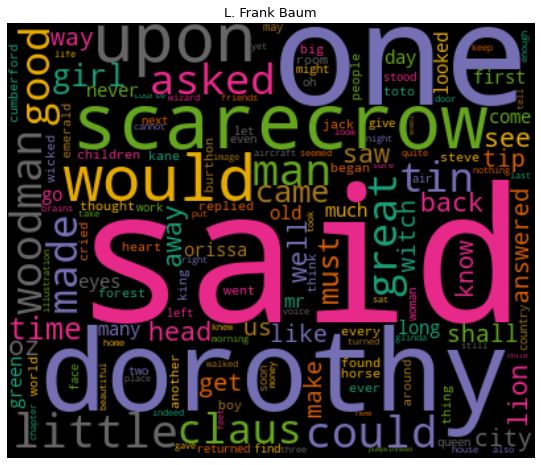

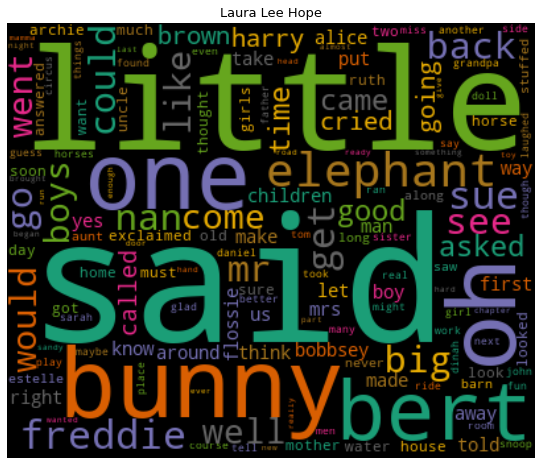

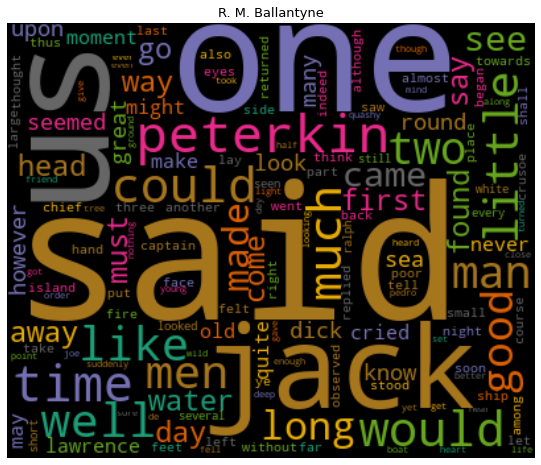

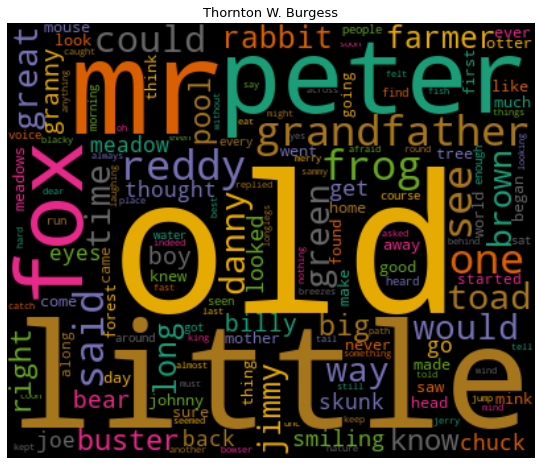

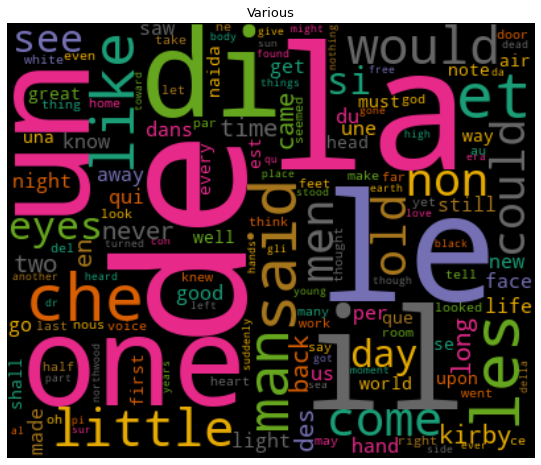

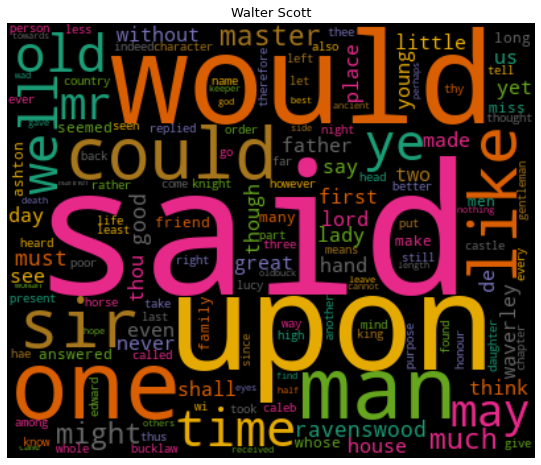

In [21]:
# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud
from textwrap import wrap

# Function for generating word clouds
def generate_wordcloud(data,title):
  wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title('\n'.join(wrap(title,60)),fontsize=13)
  plt.show()
  
# Transposing document term matrix
df_dtm=df_dtm.transpose()

# Plotting word cloud for each author
for index,author in enumerate(df_dtm.columns):
  generate_wordcloud(df_dtm[author].sort_values(ascending=False),product)

Prepare train, test dataset

In [40]:
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()

data_train['Author_Enc'] = lb.fit_transform(data_train['Author'])
data_test['Author_Enc'] = lb.fit_transform(data_test['Author'])

In [41]:
data_train.head()

,Title,Author,ID,Text,Author_Enc
0,Poems Teachers Ask For,Various,18909,poems teachers ask selected readers normal ins...,8
1,First Italian Readings,Various,24072,transcriber note text enclosed equal signs bol...,8
2,The Night Before Christmas and Other Popular S...,Various,13213,internet archive children library transcriber ...,8
3,A Christmas Hamper: A Volume of Pictures and S...,Various,53299,images public domain material google books pro...,8
4,Le Tour du Monde; Athos,Various,24515,online distributed proofreading team http www ...,8


In [42]:
X_train = data_train.Text
Y_train = data_train.Author_Enc
X_test = data_test.Text
Y_test = data_test.Author_Enc

print(f"Training data: {X_train.shape}, {Y_train.shape}")
print(f"Testing data: {X_test.shape}, {Y_test.shape}")

Training data: (70,), (70,)
Testing data: (30,), (30,)


In [43]:
train_data = data_train.copy()
test_data = data_test.copy()

In [44]:
# This function to split string in row to num_chunks parts
def chunk(in_string,num_chunks):
    chunk_size = len(in_string)//num_chunks
    if len(in_string) % num_chunks: chunk_size += 1
    iterator = iter(in_string)
    for _ in range(num_chunks):
        accumulator = list()
        for _ in range(chunk_size):
            try: accumulator.append(next(iterator))
            except StopIteration: break
        yield ''.join(accumulator)

In [45]:
n_chunk = 200
for i in range(train_data.shape[0]):
  train_data.Text[i] = list(chunk(train_data.Text[i], n_chunk))
for i in range(test_data.shape[0]):
  test_data.Text[i] = list(chunk(test_data.Text[i], n_chunk))

In [46]:
# Extend row with each parts which be splited above
train_data = train_data.explode('Text')
test_data = test_data.explode('Text')

In [47]:
train_data_sample_7000 = train_data.sample(frac =.5)
test_data_sample_3000 = test_data.sample(frac =.5)

In [48]:
train_texts = train_data_sample_7000["Text"].copy()
test_texts = test_data_sample_3000["Text"].copy()
train_labels = train_data_sample_7000.Author_Enc
test_labels = test_data_sample_3000.Author_Enc

In [56]:
len(train_texts[1])

99

In [50]:
print(train_texts.shape, test_texts.shape)

(7000,) (3000,)


3. Bag of Words with Random Forest Classifier

In [57]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 100) 

In [58]:
X_train_BoW = vectorizer.fit_transform(train_texts)
X_train_BoW = X_train_BoW.toarray()
print(X_train_BoW.shape)

(7000, 100)


In [59]:
X_test_BoW = vectorizer.transform(test_texts)
X_test_BoW = X_test_BoW.toarray()
print(X_test_BoW.shape)

(3000, 100)


In [60]:
vocab = vectorizer.get_feature_names()
print(f"Printing first 100 vocabulary samples:\n{vocab[:100]}")

Printing first 100 vocabulary samples:
['another', 'answered', 'asked', 'away', 'back', 'came', 'come', 'could', 'cried', 'day', 'de', 'even', 'ever', 'every', 'eyes', 'face', 'far', 'father', 'first', 'found', 'get', 'give', 'go', 'good', 'great', 'hand', 'head', 'heard', 'heart', 'house', 'however', 'indeed', 'king', 'know', 'last', 'left', 'let', 'life', 'like', 'little', 'long', 'look', 'looked', 'love', 'made', 'make', 'man', 'many', 'may', 'men', 'might', 'moment', 'mother', 'mr', 'much', 'must', 'never', 'night', 'nothing', 'old', 'one', 'part', 'people', 'place', 'put', 'replied', 'right', 'round', 'said', 'saw', 'say', 'see', 'seemed', 'shall', 'side', 'sir', 'soon', 'still', 'take', 'tell', 'think', 'thou', 'though', 'thought', 'three', 'thy', 'time', 'took', 'two', 'upon', 'us', 'way', 'well', 'went', 'whose', 'without', 'would', 'ye', 'yet', 'young']


In [68]:
# Random Forest apply GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rfc=RandomForestClassifier(random_state=42)
params = {
    'n_estimators': [200, 250, 300, 350, 400],
    'max_features': ['auto'],
    'min_samples_leaf': [3],
    'max_depth': [None],
    'criterion' :['gini']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=params, cv= 5)

In [69]:
CV_rfc.fit(X_train_BoW, train_labels)
print(CV_rfc.best_estimator_)
print(CV_rfc.best_params_)
print(CV_rfc.best_score_)

RandomForestClassifier(min_samples_leaf=3, n_estimators=200, random_state=42)
{'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 3, 'n_estimators': 200}
0.7114285714285715


In [73]:
rfc_BoW=RandomForestClassifier(
    random_state=42, 
    max_features='auto', 
    n_estimators= 200, 
    max_depth=None, 
    min_samples_leaf= 3,
    criterion='gini')
rfc_BoW.fit(X_train_BoW, train_labels)
pred=rfc_BoW.predict(X_test_BoW)

In [74]:
from sklearn.metrics import accuracy_score
print("Accuracy for Random Forest on CV data: ",accuracy_score(test_labels,pred))

Accuracy for Random Forest on CV data:  0.5016666666666667


TF - IDF with Random Forest Classifier

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer
#tf idf
tf_idf = TfidfVectorizer()
#applying tf idf to training data
X_train_tf = tf_idf.fit(train_texts)

In [77]:
#applying tf idf to training data
X_train_tf = tf_idf.transform(train_texts)
print("n_samples: %d, n_features: %d" % X_train_tf.shape)

n_samples: 7000, n_features: 53681


In [78]:
#transforming test data into tf-idf matrix
X_test_tf = tf_idf.transform(test_texts)
print("n_samples: %d, n_features: %d" % X_test_tf.shape)

n_samples: 3000, n_features: 53681


In [81]:
# Random Forest apply GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rfc=RandomForestClassifier(random_state=42)
params = {
    'n_estimators': [200, 250, 300],
    'max_features': ['auto'],
    'min_samples_leaf': [1],
    'max_depth': [None],
    'criterion' :['gini']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=params, cv= 5)

In [82]:
CV_rfc.fit(X_train_tf, train_labels)
print(CV_rfc.best_estimator_)
print(CV_rfc.best_params_)
print(CV_rfc.best_score_)

RandomForestClassifier(n_estimators=300, random_state=42)
{'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 300}
0.917


In [84]:
rfc_IFIDF=RandomForestClassifier(
    random_state= 42, 
    max_features='auto', 
    n_estimators= 300, 
    max_depth= None, 
    min_samples_leaf = 1,
    criterion='gini')
rfc_IFIDF.fit(X_train_tf, train_labels)
pred=rfc_IFIDF.predict(X_test_tf)

In [85]:
from sklearn.metrics import accuracy_score
print("Accuracy for Random Forest on CV data: ",accuracy_score(test_labels,pred))

Accuracy for Random Forest on CV data:  0.6903333333333334


Word2Vec

In [87]:
X_train_W2V = tf.data.Dataset.from_tensor_slices(train_texts)

In [88]:
X_test_W2V = tf.data.Dataset.from_tensor_slices(test_texts)

In [94]:
WordSet = set()
for i in range(len(train_texts)):
  words = train_texts.values[i].split(" ")
  WordSet.update(list(words))

print(len(WordSet)) 

53708


In [97]:
# Define the vocabulary size and number of words in a sequence.
vocab_size = 53708
sequence_length = 100

# Use the TextVectorization layer to normalize, split, and map strings to
# integers. Set output_sequence_length length to pad all samples to same length.
vectorize_layer = layers.TextVectorization(
    # standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

In [98]:
vectorize_layer.adapt(X_train_W2V.batch(1024))

In [99]:
# Save the created vocabulary for reference.
inverse_vocab = vectorize_layer.get_vocabulary()
print(inverse_vocab[:20])

['', '[UNK]', 'said', 'one', 'would', 'could', 'man', 'upon', 'time', 'little', 'like', 'well', 'us', 'old', 'see', 'men', 'great', 'must', 'good', 'two']


In [100]:
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE
# Vectorize the data in text_ds.
text_vector_ds = X_train_W2V.batch(1024).prefetch(AUTOTUNE).map(vectorize_layer).unbatch()

In [101]:
text_vector_ds

<_UnbatchDataset element_spec=TensorSpec(shape=(100,), dtype=tf.int64, name=None)>

In [102]:
sequences = list(text_vector_ds.as_numpy_iterator())
print(len(sequences))

7000


In [103]:
for seq in sequences[:5]:
  print(f"{seq} => {[inverse_vocab[i] for i in seq]}")

[  981   460  2723   420  8457  2642    19    19  1011   834  3900   919
   284 11551   268  1013  1929  5198  7013 14703  8349  8167  4984   290
   899   379   680   680   329 11871    55 11453   614   316   410    86
  2435  8517    94  4672   622    34    72 17997     2  2151  3526  2307
   859   265  7894   109  1926  1436   125  1491   127    55  2618   956
    65   131  1012   982   478  6355 10749    68   620  3928   799    45
  3977    55 14077  2504  1079   983  5881  1748   501   460    90  1753
  5429   738  1341  1731    98  9866   210   503  4743  3091  2502     3
    82   652   652  7117] => ['hastily', 'spot', 'armour', 'soldiers', 'rattling', 'heavily', 'two', 'two', 'proceeded', 'space', 'cavalier', 'pointed', 'green', 'semicircle', 'several', 'yards', 'extent', 'backed', 'tangled', 'copses', 'brushwood', 'sloping', 'vale', 'reached', 'safety', 'drew', 'breast', 'breast', 'form', 'crescent', 'every', 'visor', 'closed', 'save', 'knight', 'looked', 'anxiously', 'keenly',

In [104]:
# Generates skip-gram pairs with negative sampling for a list of sequences
# (int-encoded sentences) based on window size, number of negative samples
# and vocabulary size.
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
  # Elements of each training example are appended to these lists.
  targets, contexts, labels = [], [], []

  # Build the sampling table for vocab_size tokens.
  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

  # Iterate over all sequences (sentences) in dataset.
  for sequence in tqdm.tqdm(sequences):

    # Generate positive skip-gram pairs for a sequence (sentence).
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
          sequence,
          vocabulary_size=vocab_size,
          sampling_table=sampling_table,
          window_size=window_size,
          negative_samples=0)

    # Iterate over each positive skip-gram pair to produce training examples
    # with positive context word and negative samples.
    for target_word, context_word in positive_skip_grams:
      context_class = tf.expand_dims(
          tf.constant([context_word], dtype="int64"), 1)
      negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
          true_classes=context_class,
          num_true=1,
          num_sampled=num_ns,
          unique=True,
          range_max=vocab_size,
          seed=SEED,
          name="negative_sampling")
      
      # Build context and label vectors (for one target word)
      negative_sampling_candidates = tf.expand_dims(
          negative_sampling_candidates, 1)

      context = tf.concat([context_class, negative_sampling_candidates], 0)
      label = tf.constant([1] + [0]*num_ns, dtype="int64")

      # Append each element from the training example to global lists.
      targets.append(target_word)
      contexts.append(context)
      labels.append(label)

  return targets, contexts, labels

In [105]:
targets, contexts, labels = generate_training_data(
    sequences=sequences,
    window_size=2,
    num_ns=4,
    vocab_size=vocab_size,
    seed=SEED)

targets = np.array(targets)
contexts = np.array(contexts)[:,:,0]
labels = np.array(labels)

print('\n')
print(f"targets.shape: {targets.shape}")
print(f"contexts.shape: {contexts.shape}")
print(f"labels.shape: {labels.shape}")

100%|██████████| 7000/7000 [09:54<00:00, 11.78it/s]




targets.shape: (809688,)
contexts.shape: (809688, 5)
labels.shape: (809688, 5)


In [106]:
BATCH_SIZE = 1024
BUFFER_SIZE = 10000
# I go to school ==> target : I(2) context : go(10), she(4), sun(3), the(18), work (25) => 1 0 0 0 0
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<BatchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int64, name=None), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None))>


In [107]:
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
print(dataset)

<PrefetchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int64, name=None), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None))>


In [108]:
class Word2Vec(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim):
    super(Word2Vec, self).__init__()
    self.target_embedding = layers.Embedding(vocab_size,
                                      embedding_dim,
                                      input_length=1,
                                      name="w2v_embedding")
    self.context_embedding = layers.Embedding(vocab_size,
                                       embedding_dim,
                                       input_length=num_ns+1)

  def call(self, pair):
    target, context = pair
    # target: (batch, dummy?)  # The dummy axis doesn't exist in TF2.7+
    # context: (batch, context)
    if len(target.shape) == 2:
      target = tf.squeeze(target, axis=1)
    # target: (batch,)
    word_emb = self.target_embedding(target)
    # word_emb: (batch, embed)
    context_emb = self.context_embedding(context)
    # context_emb: (batch, context, embed)
    dots = tf.einsum('be,bce->bc', word_emb, context_emb)
    # dots: (batch, context)
    return dots

In [109]:
def custom_loss(x_logit, y_true):
      return tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=y_true)

In [110]:
embedding_dim = 128
num_ns = 10

word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

In [111]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [112]:
word2vec.fit(dataset, epochs=20, callbacks=[tensorboard_callback])

Epoch 1/20
790/790 [==============================] - 11s 10ms/step - loss: 1.5014 - accuracy: 0.3277
Epoch 2/20
790/790 [==============================] - 8s 10ms/step - loss: 1.3210 - accuracy: 0.4480
Epoch 3/20
790/790 [==============================] - 8s 10ms/step - loss: 1.1476 - accuracy: 0.5684
Epoch 4/20
790/790 [==============================] - 8s 10ms/step - loss: 0.9399 - accuracy: 0.7071
Epoch 5/20
790/790 [==============================] - 8s 10ms/step - loss: 0.7411 - accuracy: 0.8052
Epoch 6/20
790/790 [==============================] - 8s 10ms/step - loss: 0.5772 - accuracy: 0.8655
Epoch 7/20
790/790 [==============================] - 8s 10ms/step - loss: 0.4511 - accuracy: 0.9026
Epoch 8/20
790/790 [==============================] - 8s 10ms/step - loss: 0.3561 - accuracy: 0.9272
Epoch 9/20
790/790 [==============================] - 8s 10ms/step - loss: 0.2845 - accuracy: 0.9449
Epoch 10/20
790/790 [==============================] - 8s 10ms/step - loss: 0.2298 - accur

In [113]:
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

In [133]:
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [143]:
len(train_texts)

7000

In [152]:
train_v2w = train_texts[:700].copy()
temp_w = []
for i in range(len(train_v2w)):
  review_words = train_v2w.values[i].split()
  for word in review_words:
    temp_w.append([weights[index] for index, val in enumerate(vocab) if word == val])
  train_v2w.values[i] = temp_w
print("Cleanning training completed!")

Cleanning training completed!


In [158]:
test_v2w = test_texts[:300].copy()
temp_w = []
for i in range(len(test_v2w)):
  review_words = test_v2w.values[i].split()
  for word in review_words:
    temp_w.append([weights[index] for index, val in enumerate(vocab) if word == val])
  test_v2w.values[i] = temp_w
print("Cleanning testing completed!")

Cleanning testing completed!


In [159]:
train_v2w_label = train_labels[:700]
test_v2w_label = test_labels[:300]

In [123]:
X_train = []
for i in range(data_train_size):
    X_train.append(X_train_w2v[i][1][0])
print("Cleanning train completed!")

Cleanning train completed!


In [124]:
X_test = []
for i in range(data_test_size):
    X_test.append(X_test_w2v[i][1][0])
print("Cleanning test completed!")

Cleanning test completed!


In [164]:
X_train = np.array(train_v2w)

In [163]:
X_test = np.array(test_v2w)

In [165]:
X_train.shape

(700,)

In [128]:
# Random Forest apply GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rfc=RandomForestClassifier(random_state=42)
params = {
    'n_estimators': [10, 20, 50],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 2, 3],
    'max_depth': [None, 1, 2],
    'criterion' :['gini']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=params, cv= 3)

In [ ]:
CV_rfc.fit(X_train, train_v2w_label)
print(CV_rfc.best_estimator_)
print(CV_rfc.best_params_)
print(CV_rfc.best_score_)

RandomForestClassifier(n_estimators=10, random_state=42)
{'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 10}
0.0857487922705314


In [ ]:
rfc3=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 10, max_depth=1, criterion='gini')
rfc3.fit(X_train, train_v2w_label)
pred=rfc3.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy for Random Forest on CV data: ",accuracy_score(test_v2w_label,pred))

Accuracy for Random Forest on CV data:  0.1


BERT for author classification

In [ ]:
!pip install transformers==3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

In [ ]:
train_data = data_train.copy()
test_data = data_test.copy()

In [ ]:
def chunk(in_string,num_chunks):
    chunk_size = len(in_string)//num_chunks
    if len(in_string) % num_chunks: chunk_size += 1
    iterator = iter(in_string)
    for _ in range(num_chunks):
        accumulator = list()
        for _ in range(chunk_size):
            try: accumulator.append(next(iterator))
            except StopIteration: break
        yield ''.join(accumulator)

In [ ]:
n_chunk = 200
for i in range(train_data.shape[0]):
  train_data.Text[i] = list(chunk(train_data.Text[i], n_chunk))
for i in range(test_data.shape[0]):
  test_data.Text[i] = list(chunk(test_data.Text[i], n_chunk))

In [ ]:
train_data = train_data.explode('Text')
test_data = test_data.explode('Text')

In [ ]:
train_data_sample_7000 = train_data.sample(frac =.5)
test_data_sample_3000 = test_data.sample(frac =.5)

In [ ]:
train_texts = train_data_sample_7000["Text"].copy()
test_texts = test_data_sample_3000["Text"].copy()
train_labels = train_data_sample_7000.Author_Enc
test_labels = test_data_sample_3000.Author_Enc

In [ ]:
train_texts

15    stration teddy playing trap ball illustration ...
17    mpets blast cry saw lights thrown confusion on...
4     n qu il puisse se marier ailleurs et se faire ...
32     robe landlord found document able read confir...
61    ve wits play nearly great gravity lord bolingb...
                            ...                        
39    owns cities farmhouses expected figured enough...
64    ws green forest would better without lot bette...
0     starlight recognized maggie wife lord scourge ...
37    ied neck since queen mice given minutes heard ...
65    d buster fact surprised frightened even run se...
Name: Text, Length: 7000, dtype: object

In [ ]:
test_texts

21    son quality others least estimated chivalric v...
28     stone wall hiding snuggled beside johnny chuc...
2     ight superior virtue places lyrical ballads sa...
26    stic jealousy household treason book x return ...
20    oh ice said mrs brown laughing see daddy littl...
                            ...                        
20    all net bunny soon scooping around water catch...
2     rb internal tranquillity stamboloff became pri...
10    ot another buffalo ha dick observed wild turke...
24    mbark england friends london attack tower deli...
9     lothing night bitterly cold gaining deck found...
Name: Text, Length: 3000, dtype: object

In [ ]:
# check class distribution
train_labels.value_counts()

3    713
8    710
6    709
1    707
5    706
9    704
7    701
0    698
2    691
4    661
Name: Author_Enc, dtype: int64

In [ ]:
train_text, val_text, train_label, val_label = train_test_split(train_texts, train_labels, 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=train_labels)

# # we will use temp_text and temp_labels to create validation and test set
# val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
#                                                                 random_state=2018, 
#                                                                 test_size=0.5, 
#                                                                 stratify=temp_labels)

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
max_seq_len = 512

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_texts.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_label.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_label.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert 
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      # relu activation function
      self.relu =  nn.ReLU()
      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,10)
      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      # output layer
      x = self.fc2(x)
      # apply softmax activation
      x = self.softmax(x)
      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight= 'balanced', classes= np.unique(train_labels), y = train_labels)

print(class_wts)

[1.00286533 0.99009901 1.0130246  0.98176718 1.05900151 0.99150142
 0.98730606 0.99857347 0.98591549 0.99431818]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 20

In [ ]:
# function to train the model
def train():
  
  model.train()
  
  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch
    
    # clear previously calculated gradients 
    model.zero_grad()        
    
    # get model predictions for the current batch
    preds = model(sent_id, mask)
    
    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)
    
    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 20
  Batch    50  of    154.
  Batch   100  of    154.
  Batch   150  of    154.

Evaluating...
  Batch    50  of     66.

Training Loss: 1.127
Validation Loss: 0.990

 Epoch 2 / 20
  Batch    50  of    154.
  Batch   100  of    154.
  Batch   150  of    154.

Evaluating...
  Batch    50  of     66.

Training Loss: 1.002
Validation Loss: 0.922

 Epoch 3 / 20
  Batch    50  of    154.
  Batch   100  of    154.
  Batch   150  of    154.

Evaluating...
  Batch    50  of     66.

Training Loss: 0.922
Validation Loss: 0.800

 Epoch 4 / 20
  Batch    50  of    154.
  Batch   100  of    154.
  Batch   150  of    154.

Evaluating...
  Batch    50  of     66.

Training Loss: 0.852
Validation Loss: 0.764

 Epoch 5 / 20
  Batch    50  of    154.
  Batch   100  of    154.
  Batch   150  of    154.

Evaluating...
  Batch    50  of     66.

Training Loss: 0.797
Validation Loss: 0.704

 Epoch 6 / 20
  Batch    50  of    154.
  Batch   100  of    154.
  Batch   150  of    154.

Evaluating.

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

RuntimeError: ignored

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

7. K-Mean Clustering

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# import other required libs
import pandas as pd
import numpy as np

# string manipulation libs
import re
import string
import nltk
from nltk.corpus import stopwords

# viz libs
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train_data_kmean = data_train.copy()

In [ ]:
clean_words = train_data_kmean.Text.values

In [ ]:
# initialize the vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X = vectorizer.fit_transform(clean_words)

In [ ]:
# initialize kmeans with 3 centroids
kmeans = KMeans(n_clusters=10, random_state=42)
# fit the model
kmeans.fit(X)
# store cluster labels in a variable
clusters = kmeans.labels_

In [ ]:
# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(X.toarray())
# save our two dimensions into x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

In [ ]:
# assign clusters and pca vectors to our dataframe 
train_data_kmean['cluster'] = clusters
train_data_kmean['x0'] = x0
train_data_kmean['x1'] = x1

In [ ]:
def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    train_data_kmean = pd.DataFrame(X.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out() # access tf-idf terms
    for i,r in train_data_kmean.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(10)


Cluster 0
jack,natives,git,ay,observed,schooner,savages,hallo,wos,canoe

Cluster 1
knowest,nay,passions,hast,vices,honour,amidst,thou,thy,thee

Cluster 2
queen,kansas,toto,tin,santa,wizard,dorothy,woodman,claus,scarecrow

Cluster 3
peter,rabbit,muskrat,otter,jerry,billy,skunk,mink,jimmy,reddy

Cluster 4
ony,nae,ower,scotland,wad,wi,weel,sae,auld,hae

Cluster 5
brother,upon,whose,mother,master,labor,men,child,free,slave

Cluster 6
saul,jerusalem,jacob,david,ruth,israel,bethlehem,moses,israelites,jesus

Cluster 7
elephant,bert,big,mamma,doll,mrs,barn,claus,bobbsey,christmas

Cluster 8
fighting,town,attack,garrison,cavalry,men,siege,infantry,defenders,troops

Cluster 9
se,les,sa,la,es,il,ing,un,di,che


In [ ]:
train_data_kmean[train_data_kmean.Author_Enc == 9]

,Title,Author,ID,Text,Author_Enc,cluster,x0,x1
49,Ivanhoe: A Romance,Walter Scott,82,illustration ivanhoe romance sir walter scott ...,9,1,-0.362655,0.132363
50,"Waverley; Or, 'Tis Sixty Years Since",Walter Scott,5998,illustration illustration illustration waverle...,9,4,-0.349569,0.123140
51,Rob Roy — Complete,Walter Scott,7025,rob roy complete sir walter scott illustration...,9,4,-0.332741,0.119869
52,The Bride of Lammermoor,Walter Scott,471,bride lammermoor sir walter scott contents int...,9,4,-0.316922,0.158975
53,Letters on Demonology and Witchcraft,Walter Scott,14461,proofreading team letters demonology witchcraf...,9,4,-0.301739,0.131573
54,The Antiquary — Complete,Walter Scott,7005,antiquary sir walter scott bart illustration t...,9,4,-0.304932,0.117538
55,The Bride of Lammermoor,Walter Scott,471,bride lammermoor sir walter scott contents int...,9,4,-0.316922,0.158975


In [ ]:
# map clusters to appropriate labels 
cluster_map = {0: "Anonymous", 
               1: "Baron Edward Bulwer Lytton Lytton", 
               2: "G. A. Henty",
               3: "Georg Ebers",
               4: "L. Frank Baum",
               5: "Laura Lee Hope",
               6: "R. M. Ballantyne",
               7: "Thornton W. Burgess",
               8: "Various",
               9: "Walter Scott"}
# apply mapping
train_data_kmean['cluster'] = train_data_kmean['cluster'].map(cluster_map)

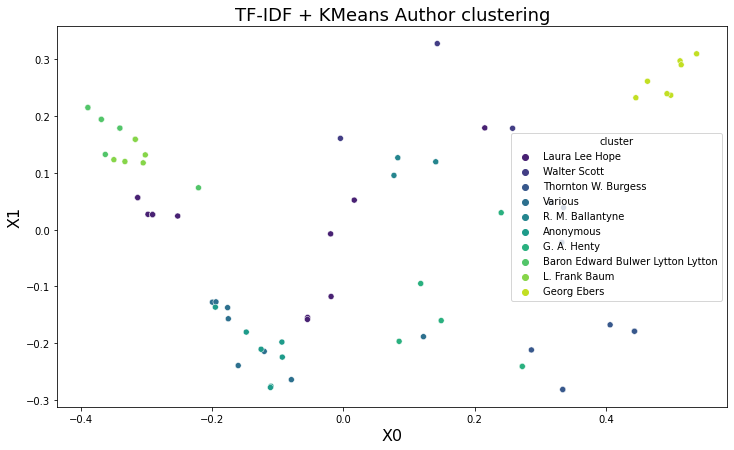

In [ ]:
# set image size
plt.figure(figsize=(12, 7))
# set a title
plt.title("TF-IDF + KMeans Author clustering", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=train_data_kmean, x='x0', y='x1', hue='cluster', palette="viridis")
plt.show()

LSA (Latent Semantic Analysis)

In [ ]:
import os
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [ ]:
train_data_lsa = data_train.copy()
test_data_lsa = data_test.copy()

In [ ]:
clean_words = train_data_lsa.Text.values

In [ ]:
# Initialize regex tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# Vectorize document using TF-IDF
tfidf = TfidfVectorizer(lowercase=True,
                        stop_words='english',
                        ngram_range = (1,1),
                        tokenizer = tokenizer.tokenize)

# Fit and Transform the documents
train_data = tfidf.fit_transform(clean_words)

In [ ]:
# Define the number of topics or components
num_components=10

# Create SVD object
lsa = TruncatedSVD(n_components=num_components, n_iter=100, random_state=42)

# Fit SVD model on data
lsa.fit_transform(train_data)

# Get Singular values and Components 
Sigma = lsa.singular_values_ 
V_transpose = lsa.components_.T

In [ ]:
# Print the topics with their terms
terms = tfidf.get_feature_names()

for index, component in enumerate(lsa.components_):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Author "+str(index)+": ",top_terms_list)

Author 0:  ['said', 'little', 'man', 'time', 'old', 'like', 'great', 'good', 'day', 'men']
Author 1:  ['bert', 'freddie', 'little', 'mr', 'peter', 'nan', 'reddy', 'flossie', 'danny', 'harry']
Author 2:  ['peterkin', 'jack', 'ralph', 'island', 'coral', 'sea', 'natives', 'makarooroo', 'schooner', 'captain']
Author 3:  ['bert', 'freddie', 'nan', 'harry', 'flossie', 'bobbsey', 'peterkin', 'snoop', 'dinah', 'sarah']
Author 4:  ['peterkin', 'pentaur', 'paaker', 'nefert', 'anat', 'ameni', 'katuti', 'rameses', 'ani', 'jack']
Author 5:  ['elephant', 'archie', 'dorothy', 'scarecrow', 'woodman', 'claus', 'oz', 'stuffed', 'christmas', 'elsie']
Author 6:  ['scarecrow', 'dorothy', 'woodman', 'oz', 'tin', 'toto', 'witch', 'lion', 'glinda', 'emerald']
Author 7:  ['ravenswood', 'ashton', 'bucklaw', 'caleb', 'lucy', 'hae', 'pentaur', 'paaker', 'master', 'craigengelt']
Author 8:  ['rienzi', 'elephant', 'montreal', 'adrian', 'archie', 'colonna', 'peterkin', 'glaucus', 'ione', 'tribune']
Author 9:  ['claus

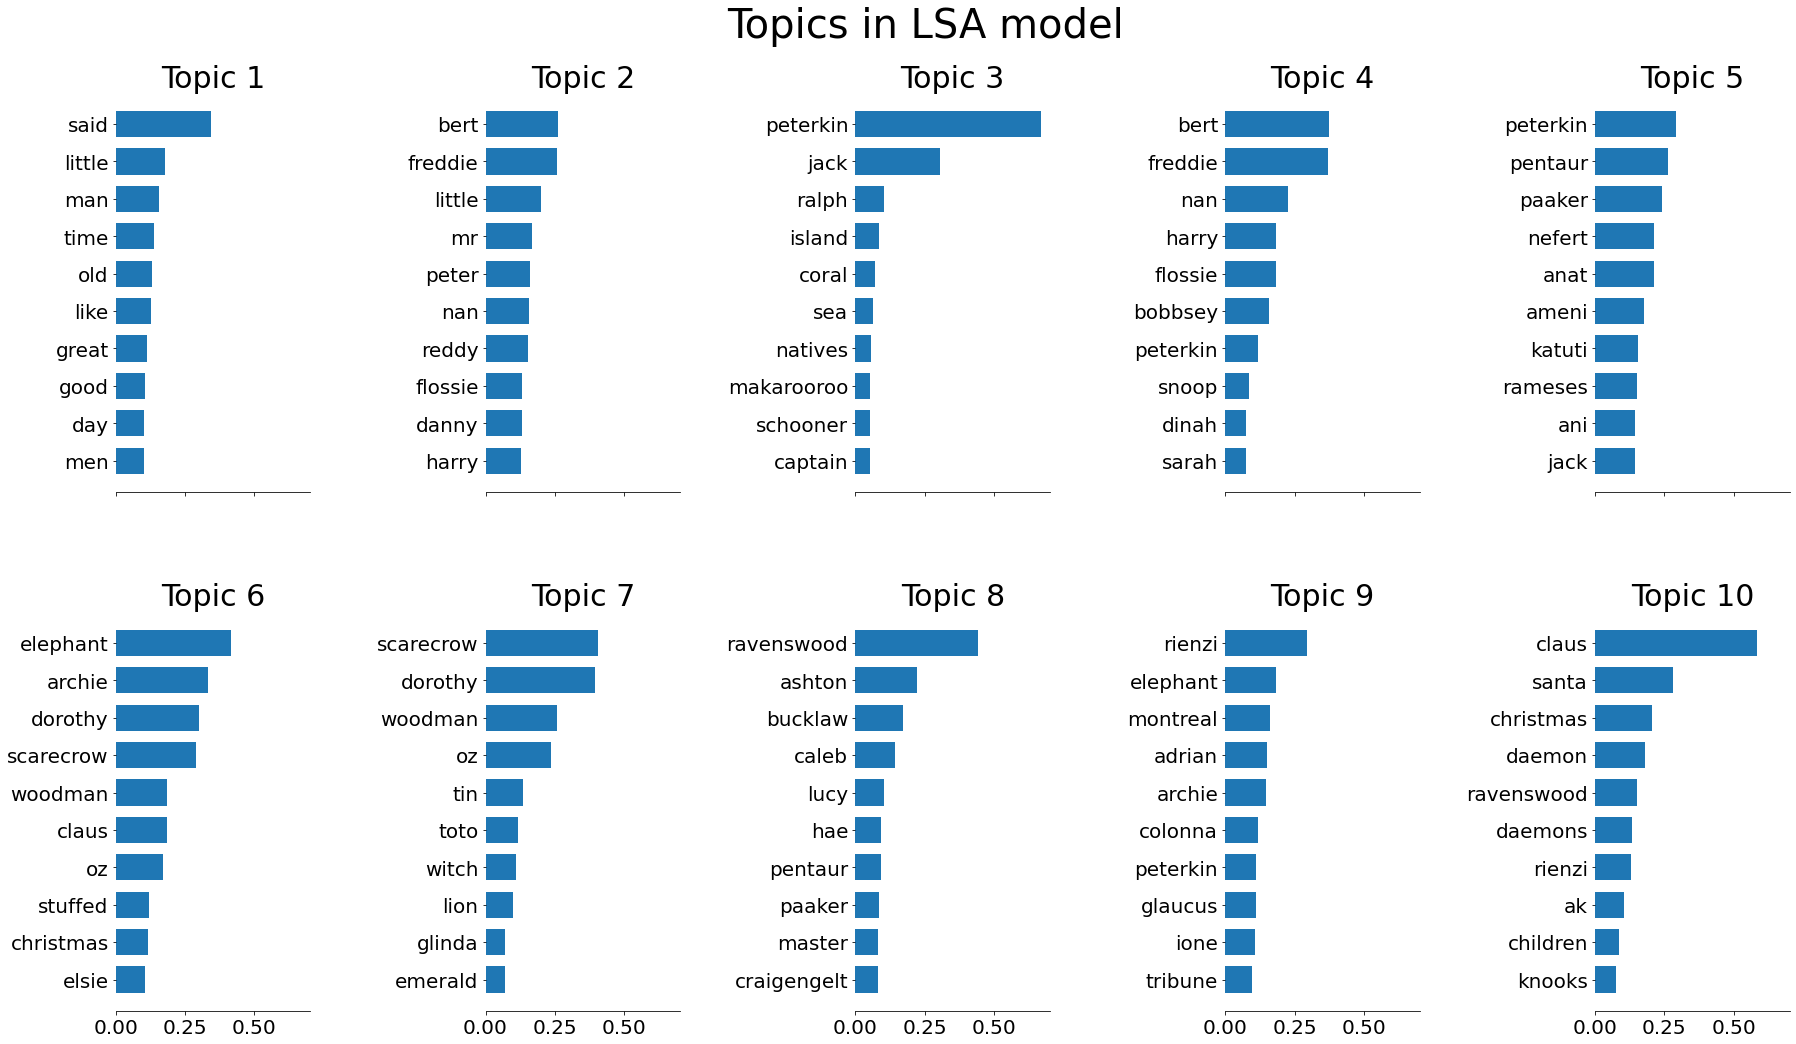

In [ ]:
plot_top_words(lsa, terms, n_top_words, "Topics in LSA model")

LDA (Latent Dirichlet Allocation)

In [ ]:
train_data_lda = data_train.copy()
test_data_lda = data_test.copy()

In [ ]:
clean_corpus = [words.split() for words in train_data_lda.Text.values]

In [ ]:
# Define corpora dictionary
import gensim
# from gensim.corpora import Dictionary
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# Creating the term dictionary of our courpus that is of all the words
dict_ = gensim.corpora.Dictionary(clean_corpus)

In [ ]:
# Converting text into numerical representation
tf_idf_vectorizer = TfidfVectorizer(tokenizer=lambda clean_words : clean_words, lowercase=False)

# Converting text into numerical representation
cv_vectorizer = CountVectorizer(tokenizer=lambda clean_words : clean_words, lowercase=False)

In [ ]:
# Converting list of documents into Document Term Matrix using the dictionary
doc_term_matrix = [dict_.doc2bow(i) for i in clean_corpus]
doc_term_matrix

In [ ]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel 

In [ ]:
# Running and Training LDA model on the document term matrix
ldamodel = Lda(doc_term_matrix, num_topics=10, id2word=dict_, passes=1, random_state=42, eval_every=None)

In [ ]:
# Prints the topics with the indexes: 0, 1, 2
ldamodel.print_topics()

[(0,
  '0.008*"said" + 0.006*"would" + 0.005*"one" + 0.005*"could" + 0.004*"man" + 0.003*"time" + 0.003*"like" + 0.003*"well" + 0.003*"old" + 0.003*"great"'),
 (1,
  '0.006*"said" + 0.006*"one" + 0.005*"would" + 0.004*"upon" + 0.003*"us" + 0.003*"could" + 0.003*"little" + 0.003*"men" + 0.003*"man" + 0.003*"time"'),
 (2,
  '0.010*"said" + 0.005*"one" + 0.004*"would" + 0.004*"could" + 0.004*"like" + 0.003*"man" + 0.003*"time" + 0.003*"little" + 0.003*"see" + 0.003*"great"'),
 (3,
  '0.006*"one" + 0.005*"said" + 0.005*"would" + 0.004*"could" + 0.004*"upon" + 0.003*"man" + 0.003*"day" + 0.003*"well" + 0.003*"old" + 0.003*"see"'),
 (4,
  '0.011*"said" + 0.007*"would" + 0.006*"one" + 0.004*"man" + 0.004*"could" + 0.004*"well" + 0.003*"time" + 0.003*"little" + 0.003*"good" + 0.003*"us"'),
 (5,
  '0.010*"said" + 0.008*"one" + 0.004*"would" + 0.004*"little" + 0.003*"like" + 0.003*"could" + 0.003*"upon" + 0.003*"time" + 0.003*"man" + 0.003*"men"'),
 (6,
  '0.009*"said" + 0.006*"one" + 0.005*"wou

In [ ]:
display(ldamodel.print_topics(num_topics=10, num_words=10))

[(0,
  '0.008*"said" + 0.006*"would" + 0.005*"one" + 0.005*"could" + 0.004*"man" + 0.003*"time" + 0.003*"like" + 0.003*"well" + 0.003*"old" + 0.003*"great"'),
 (1,
  '0.006*"said" + 0.006*"one" + 0.005*"would" + 0.004*"upon" + 0.003*"us" + 0.003*"could" + 0.003*"little" + 0.003*"men" + 0.003*"man" + 0.003*"time"'),
 (2,
  '0.010*"said" + 0.005*"one" + 0.004*"would" + 0.004*"could" + 0.004*"like" + 0.003*"man" + 0.003*"time" + 0.003*"little" + 0.003*"see" + 0.003*"great"'),
 (3,
  '0.006*"one" + 0.005*"said" + 0.005*"would" + 0.004*"could" + 0.004*"upon" + 0.003*"man" + 0.003*"day" + 0.003*"well" + 0.003*"old" + 0.003*"see"'),
 (4,
  '0.011*"said" + 0.007*"would" + 0.006*"one" + 0.004*"man" + 0.004*"could" + 0.004*"well" + 0.003*"time" + 0.003*"little" + 0.003*"good" + 0.003*"us"'),
 (5,
  '0.010*"said" + 0.008*"one" + 0.004*"would" + 0.004*"little" + 0.003*"like" + 0.003*"could" + 0.003*"upon" + 0.003*"time" + 0.003*"man" + 0.003*"men"'),
 (6,
  '0.009*"said" + 0.006*"one" + 0.005*"wou

In [ ]:
# Print the topic associations with the documents
count = 0
for i in ldamodel[doc_term_matrix]:
  print("doc: ", count, i)
  count += 1

doc:  0 [(0, 0.29953307), (1, 0.0926392), (3, 0.054075293), (4, 0.15669137), (5, 0.12084024), (6, 0.06669559), (7, 0.10013431), (8, 0.02059001), (9, 0.079838686)]
doc:  1 [(1, 0.9998074)]
doc:  2 [(0, 0.011317692), (4, 0.39715868), (5, 0.49768898), (8, 0.08114525)]
doc:  3 [(0, 0.07932693), (2, 0.086793214), (4, 0.2670922), (5, 0.43437818), (6, 0.0138486335), (7, 0.011650066), (8, 0.09585352)]
doc:  4 [(0, 0.042171977), (8, 0.957392)]
doc:  5 [(0, 0.5135514), (4, 0.055723637), (5, 0.027555667), (6, 0.09498993), (7, 0.28479865)]
doc:  6 [(0, 0.20456214), (2, 0.105715364), (3, 0.05769033), (4, 0.29158193), (5, 0.03588041), (6, 0.011099604), (7, 0.10324284), (8, 0.010886165), (9, 0.17596583)]
doc:  7 [(0, 0.054295074), (1, 0.020665793), (2, 0.07228606), (3, 0.13312824), (4, 0.40824795), (5, 0.06386977), (6, 0.051349405), (8, 0.17449036), (9, 0.011997396)]
doc:  8 [(1, 0.41427228), (2, 0.115402825), (3, 0.061433032), (4, 0.2200858), (6, 0.011015034), (7, 0.046338093), (8, 0.03522623), (9, 

In [ ]:
# Get array from TF-IDF Vectorizer
tf_idf_arr = tf_idf_vectorizer.fit_transform(clean_corpus)

# Get array from CountVectorizer
cv_arr = cv_vectorizer.fit_transform(clean_corpus)

In [ ]:
tf_idf_arr

<70x64880 sparse matrix of type '<class 'numpy.float64'>'
	with 455513 stored elements in Compressed Sparse Row format>

In [ ]:
cv_arr

<70x64880 sparse matrix of type '<class 'numpy.int64'>'
	with 455513 stored elements in Compressed Sparse Row format>

In [ ]:
# Creating vocabulary array which will represent all the corpus
vocab_tf_idf = tf_idf_vectorizer.get_feature_names()

# get the vocab list
vocab_tf_idf

['aahmes',
 'aalu',
 'aaron',
 'ab',
 'aback',
 'abacus',
 'abaissement',
 'abana',
 'abandon',
 'abandoned',
 'abandoning',
 'abandonment',
 'abandonn',
 'abandons',
 'abare',
 'abart',
 'abase',
 'abased',
 'abasement',
 'abash',
 'abashed',
 'abasing',
 'abate',
 'abated',
 'abatement',
 'abates',
 'abating',
 'abattis',
 'abb',
 'abbachie',
 'abbacy',
 'abbaiare',
 'abbair',
 'abbandon',
 'abbandonando',
 'abbandonare',
 'abbandoner',
 'abbarach',
 'abbas',
 'abbassare',
 'abbassate',
 'abbassava',
 'abbasso',
 'abbastanza',
 'abbattimento',
 'abbe',
 'abbelliranno',
 'abbellire',
 'abbelliscono',
 'abberbredok',
 'abbess',
 'abbeville',
 'abbey',
 'abbeys',
 'abbi',
 'abbia',
 'abbiam',
 'abbiamo',
 'abbiate',
 'abbies',
 'abbigliamenti',
 'abbigliamento',
 'abbisogna',
 'abbisognare',
 'abbon',
 'abbondantissima',
 'abbot',
 'abbots',
 'abbotsford',
 'abbott',
 'abbracci',
 'abbracciandole',
 'abbracciare',
 'abbracciati',
 'abbreviated',
 'abbreviations',
 'abbrunata',
 'abbruna

In [ ]:
# Implementation of LDA
lda_model = LatentDirichletAllocation(n_components = 10, max_iter = 100, random_state = 42)
X_topics = lda_model.fit_transform(tf_idf_arr)

In [ ]:
# Component give us our topic distribution
topic_words = lda_model.components_

In [ ]:
n_top_words = 10

for i, topic_dist in enumerate(topic_words):
  # Sorting an array or a list or the matrix acc to their values
  sorted_topic_dist = np.argsort(topic_dist)

  # Next to view the actual words present in those indexes we can make the use of the vocab created earlier
  topic_words = np.array(vocab_tf_idf)[sorted_topic_dist]

  topic_words = topic_words[:-n_top_words:-1]
  print("Topic", str(i+1), topic_words)

Topic 1 ['archie' 'lazaro' 'sidenote' 'orissa' 'cumberford' 'elsie' 'burthon'
 'kane' 'steve']
Topic 2 ['che' 'il' 'un' 'si' 'una' 'non' 'gli' 'della' 'pi']
Topic 3 ['ravenswood' 'ashton' 'kirby' 'bucklaw' 'naida' 'caleb' 'craigengelt'
 'duca' 'babie']
Topic 4 ['gr' 'kendall' 'obble' 'tad' 'winkler' 'flyaways' 'ch' 'lollypops' 'lui']
Topic 5 ['said' 'one' 'would' 'little' 'could' 'man' 'time' 'old' 'upon']
Topic 6 ['gr' 'kendall' 'obble' 'tad' 'winkler' 'flyaways' 'ch' 'lollypops' 'lui']
Topic 7 ['isora' 'gerald' 'vril' 'montreuil' 'devereux' 'gy' 'ya' 'zee' 'glauran']
Topic 8 ['gr' 'kendall' 'obble' 'tad' 'winkler' 'flyaways' 'ch' 'lollypops' 'lui']
Topic 9 ['les' 'le' 'et' 'une' 'dans' 'des' 'du' 'un' 'nous']
Topic 10 ['peterkin' 'bert' 'freddie' 'buster' 'nan' 'glaucus' 'ione' 'bartja'
 'arbaces']


In [ ]:
# # To view what topics are assigned tho the document
# doc_topic = lda_model.transform(tf_idf_arr)

# # iterating over ever value till the end value
# for n in range(doc_topic.shape[0]):
#                # argmax() gives maximum index value
#                topic_doc = doc_topic[n].argmax()

#                # document is n+1
#                print("Author: ", n+1, "-- Topic: ", topic_doc)

In [ ]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

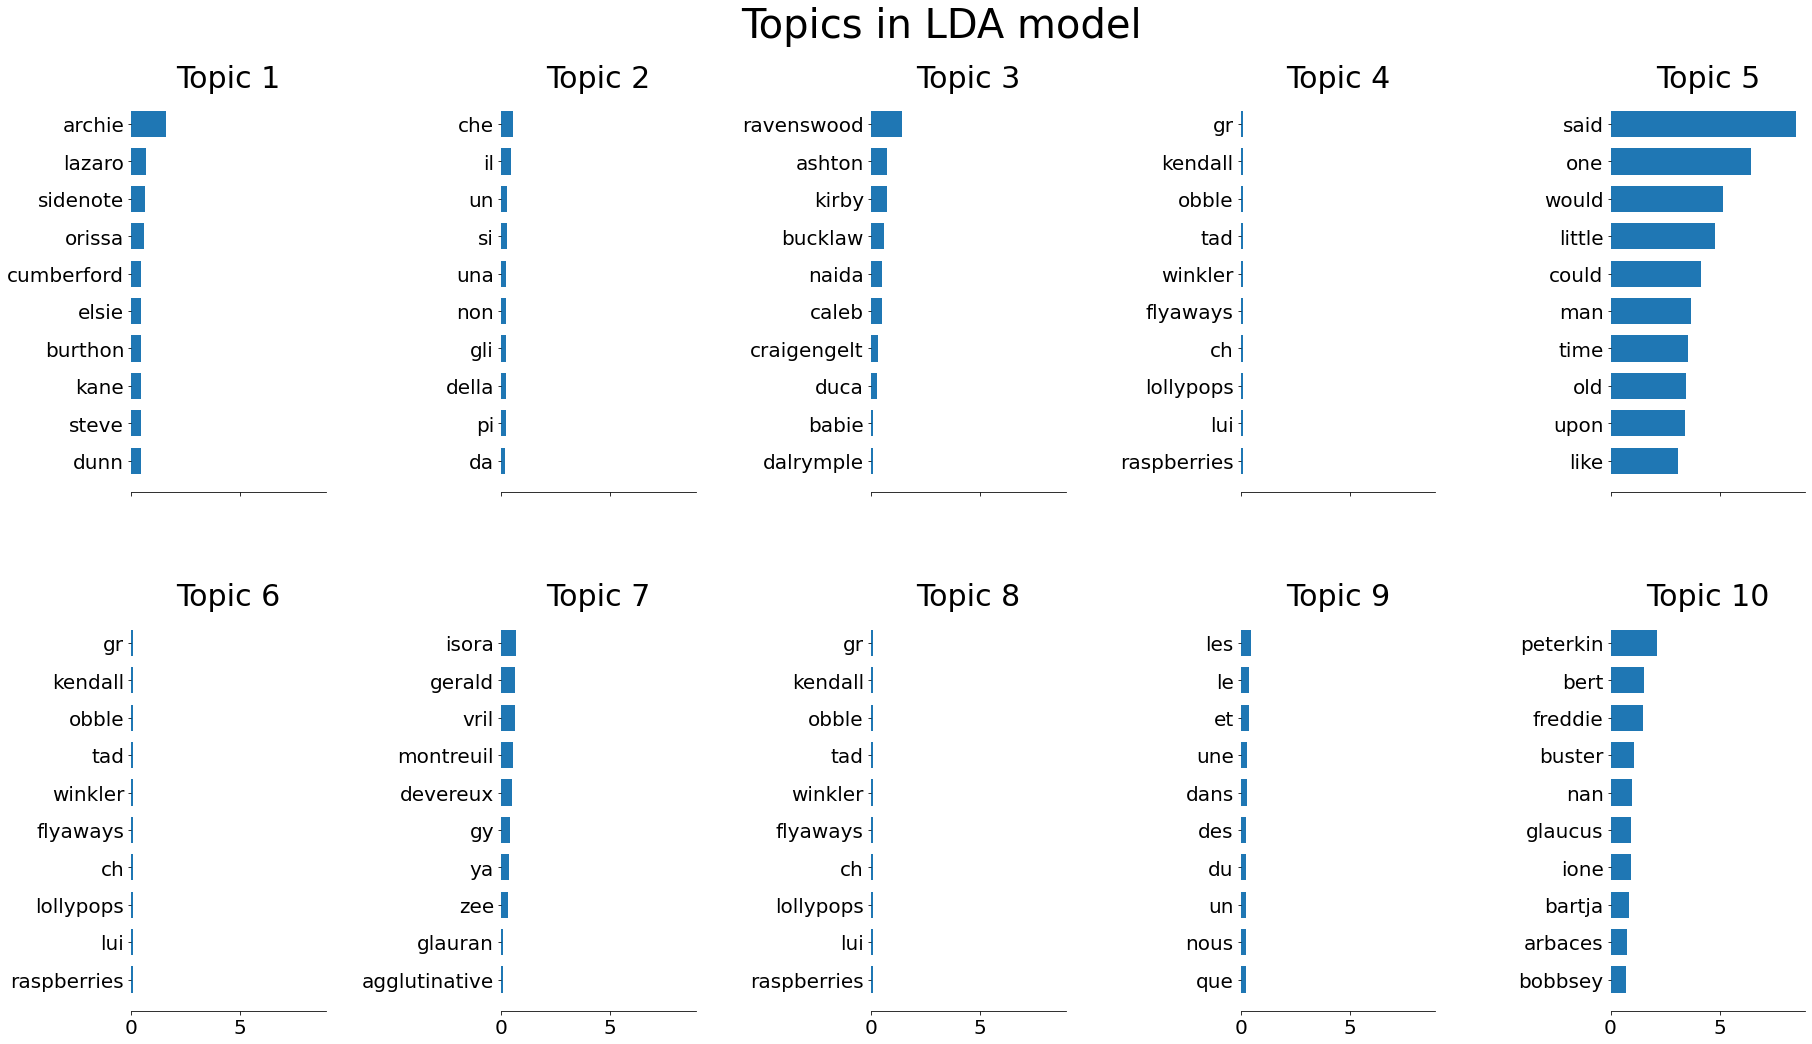

In [ ]:
plot_top_words(lda_model, vocab_tf_idf, n_top_words, "Topics in LDA model")

Non-Negative Matrix Factorization

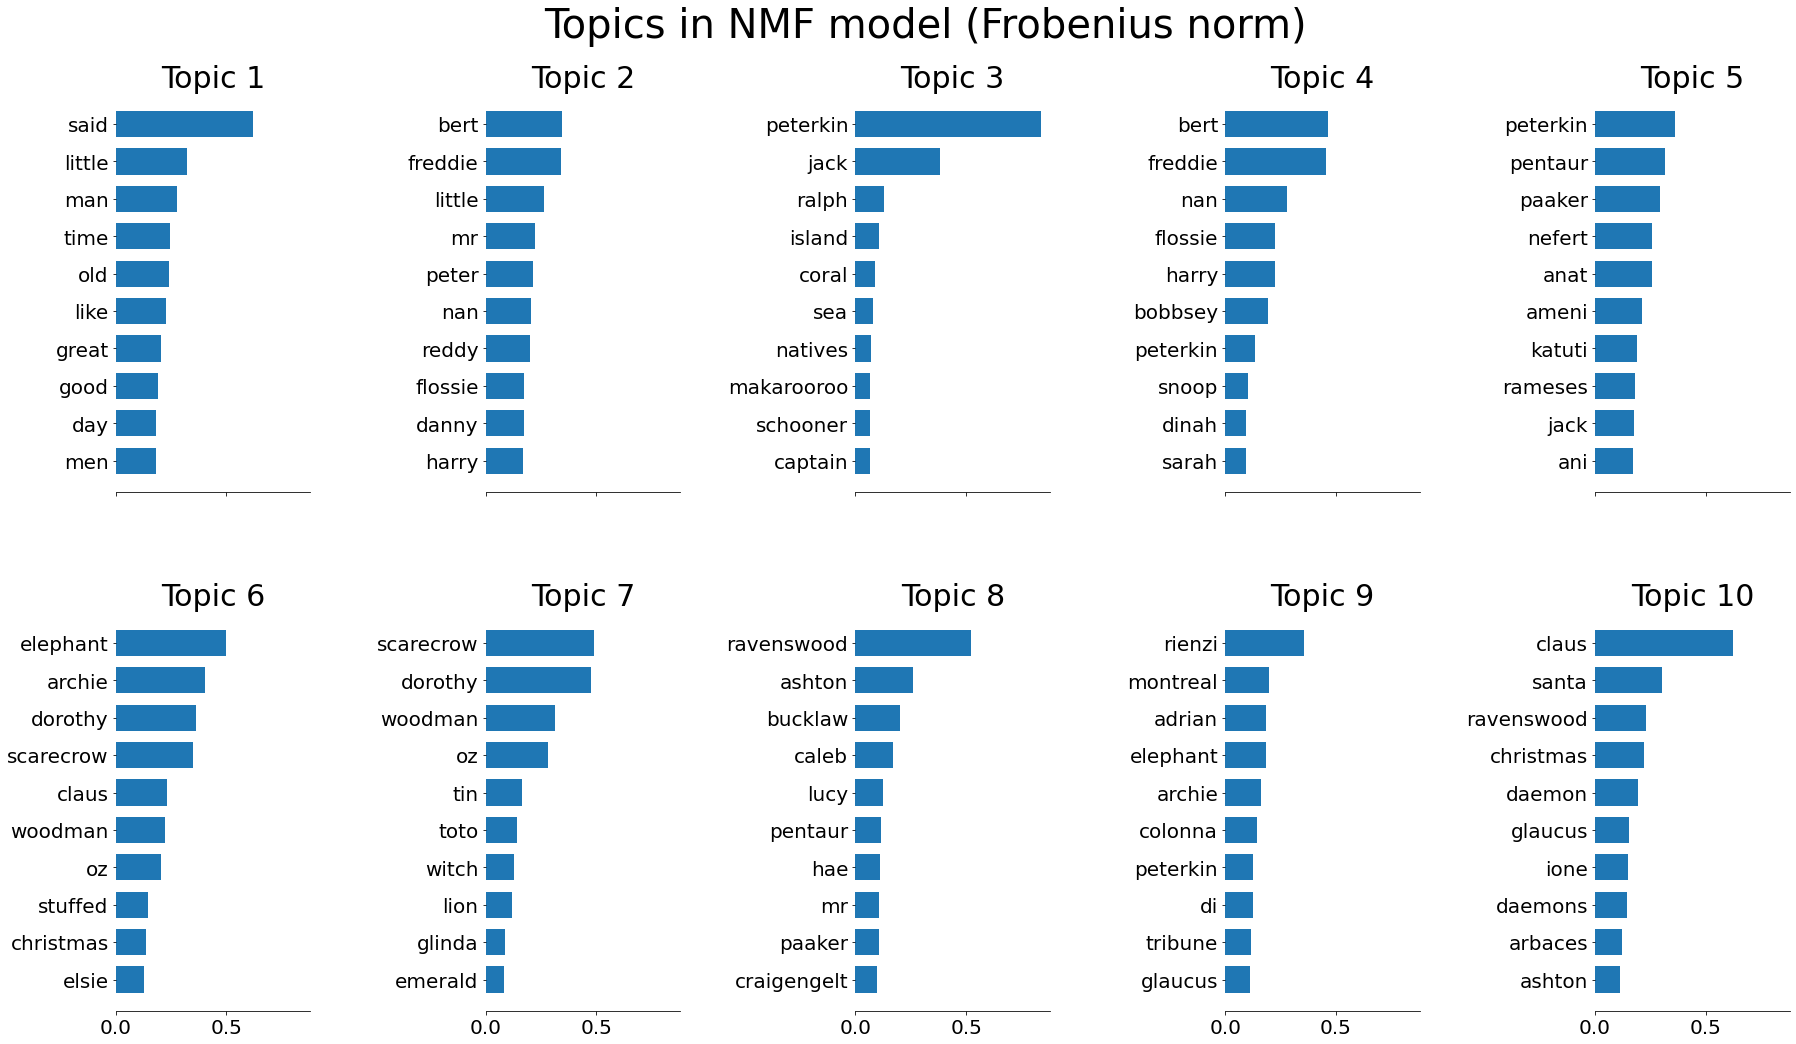

In [ ]:
from sklearn.decomposition import NMF
nmf = NMF(
    n_components=10,
    random_state=1,
    init="nndsvda",
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(train_data)


tfidf_feature_names = tfidf.get_feature_names_out()
plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)"
)